In [11]:
import numpy as np
import pandas as pd
import scipy.optimize
from scipy.misc import derivative
import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18}
sns.set(rc=rc)

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

## Utility functions

In [12]:
def get_data(place_name):
    filename = place_name + '.csv'
    df = pd.read_csv(filename, index_col=0)
    return df

#get_data('Hawaii')

In [13]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

## Model definitions

In [14]:
def exponential_model(t, nz, r):
    return nz*np.exp(r*t)

In [15]:
def linear_model(t, y_intercept, slope):
    return y_intercept + slope * t

In [16]:
def quadratic_model(t, n0, c1, c2):
    return n0 + c1*t + c2*t*t

In [17]:
# See https://www.kaggle.com/hotstaff/fitting-to-logistic-function-and-graph-drawing

def logistic_model(t, K, P0, r):
    return  (K / (1 + ((K-P0)/P0)*np.exp(-r*t)))

## Curve fitter

In [18]:
def fit_curve(place_name, df, model, p0, extrapolated_days=0):
    
    # Create list of days since first case confirmed
    days = [i for i in range(df.size)]

    # Do curve fit, but dump covariance into dummy variable
    p, _ = scipy.optimize.curve_fit(model, days, df.cases, p0)
    
    # Calculate RMS error for fitted model
    targets = df.cases.values
    predictions = [model(day, *tuple(p)) for day in days]
    rms_error = rmse(predictions, targets)  
    
    # Calc x and y values for fitted curve (100 values between zero and max(days) plus extrapolated days
    x_smooth = np.linspace(0, max(days), 100)
    y_smooth = model(x_smooth, *tuple(p))
    
    # Calc x, y for extrapolation
    if extrapolated_days > 0:
        x = np.linspace(max(days), max(days)+extrapolated_days, 100)
        y = model(x, *tuple(p))
        plt.plot(x, y, marker='None', linestyle='dotted', color='gray')

    # Plot everything together
    plt.plot(x_smooth, y_smooth, marker='None', linestyle='-', color='gray')
    plt.plot(days, df.cases, marker='o', linestyle='none')

    # make plot title and Label axes
    if model == linear_model: 
        plt.title('{}\nLast data point: {} UTC\nLinear model\nn0={:.0f}, slope={:.2f}, RMS error={:.2f}'
            .format(place_name, df.index[-1], p[0], p[1], rms_error)),       
    if model == quadratic_model: 
        plt.title('{}\nLast data point: {} UTC\nQuadratic model\nn0={:.0f}, c1={:.2f}, c2={:.2f},RMS error={:.2f}'
            .format(place_name, df.index[-1], p[0], p[1], p[2], rms_error)),                          
    if model == exponential_model: 
        plt.title('{}\nLast data point: {} UTC\nExponential model\nn0={:.0f}, r={:.2f}, RMS error={:.2f}'
            .format(place_name, df.index[-1], p[0], p[1], rms_error)),    
    if model == logistic_model: 
        plt.title('{}\nLast data point: {} UTC\nLogistic model\nn0={:.0f}, r={:.2f}, k={:.0f}, RMS error={:.2f}'
            .format(place_name, df.index[-1], p[1], p[2], p[0], rms_error))     
    plt.xlabel('days since 1st confirmed case')
    plt.ylabel('confirmed cases')
    
    # Save plot to files
    plt.savefig('images/{}-{}-{}.png'.format(place_name, model.__name__, df.index[-1]), bbox_inches='tight')
    plt.savefig('images/{}-{}-latest.png'.format(place_name, model.__name__), bbox_inches='tight')
    
    plt.show()
    plt.close()   
    
    return

#fit_curve('Hawaii', df, logistic_model, p0_logistic, 10)

## Plot logistic model derivative

In [19]:
def plot_logistic_model_derivative(place_name):
    df = get_data(place_name)
    days = [i for i in range(df.size)]

    # Do curve fit, but dump covariance into dummy variable
    p, _ = scipy.optimize.curve_fit(logistic_model, days, df.cases, p0_logistic)

    # Calculate RMS error for fitted model
    targets = df.cases.values
    predictions = [logistic_model(day, *tuple(p)) for day in days]
    rms_error = rmse(predictions, targets)  

    # plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    #ax2 = ax1.twiny()
    #ax2.set_xlim(ax1.get_xlim())

    x = np.linspace(0, max(days)+10, 100)
    y = derivative(logistic_model, x, dx=0.001, args=p)
    #plt.plot(x, logistic_model(x, *p))
    ax1.plot(x, y)
    plt.title('{}\nLast data point: {} UTC\nLogistic model derivative\nn0={:.0f}, r={:.2f}, k={:.0f}, RMS error={:.2f}'
        .format(place_name, df.index[-1], p[1], p[2], p[0], rms_error)) 
    ax1.set_xlabel('days since 1st confirmed case')
    ax1.set_ylabel('confirmed cases');
    #ax2.axis( ymin=ax1.ymin, ymax=ax1.ymax )

    # Save plot to files
    plt.savefig('images/{}-logistic-model-derivative-{}.png'.format(place_name, df.index[-1]), bbox_inches='tight')
    plt.savefig('images/{}-logistic-model-derivative-latest.png'.format(place_name), bbox_inches='tight')
    
    plt.close()
    
    return

# MAIN

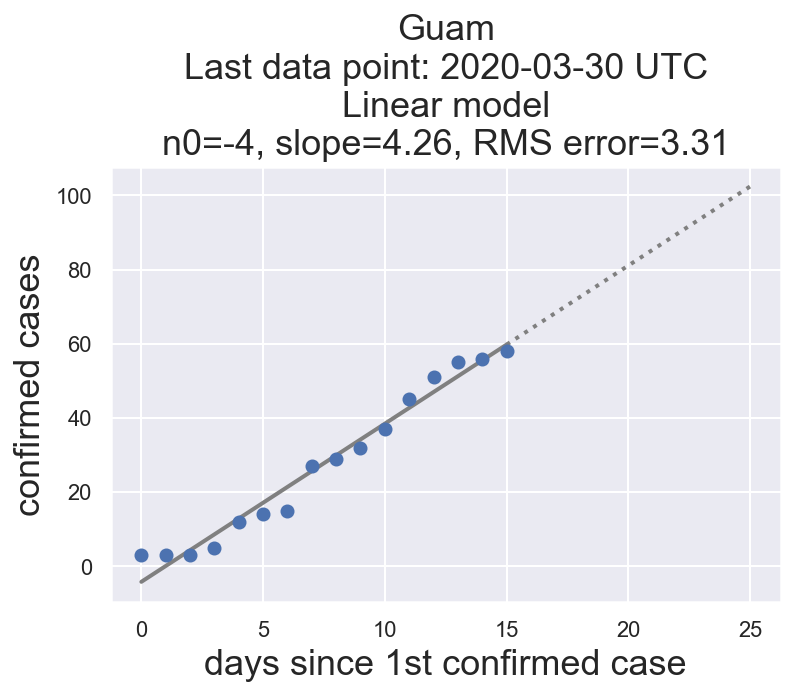

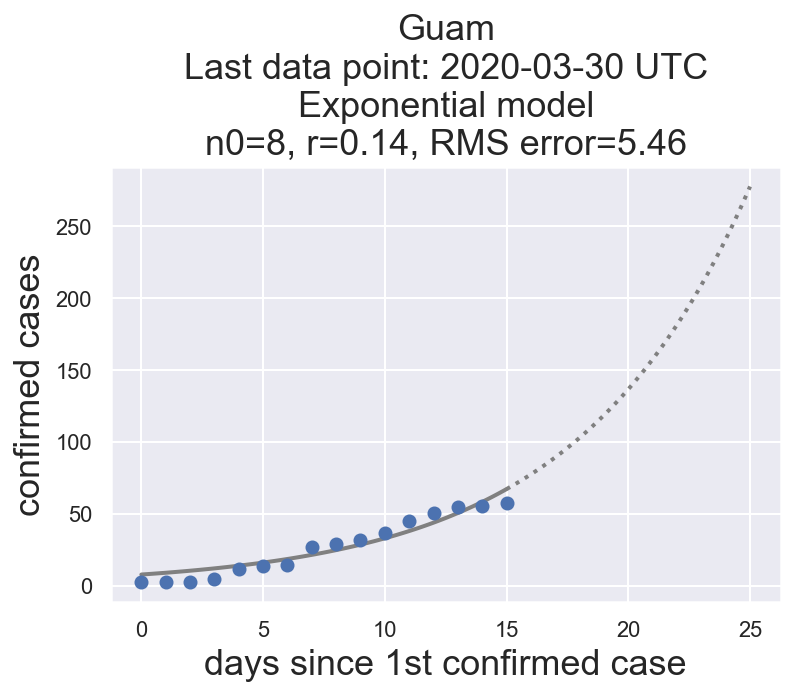

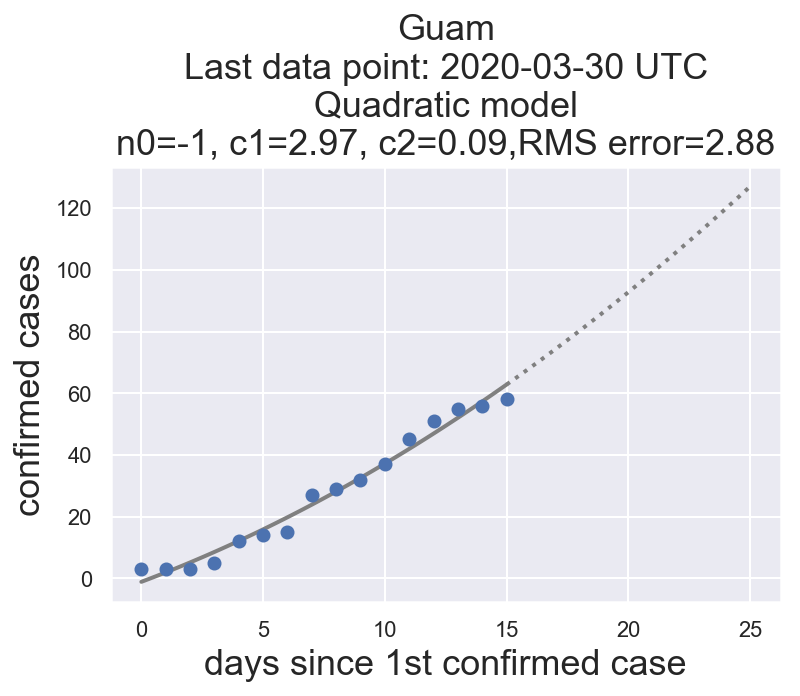

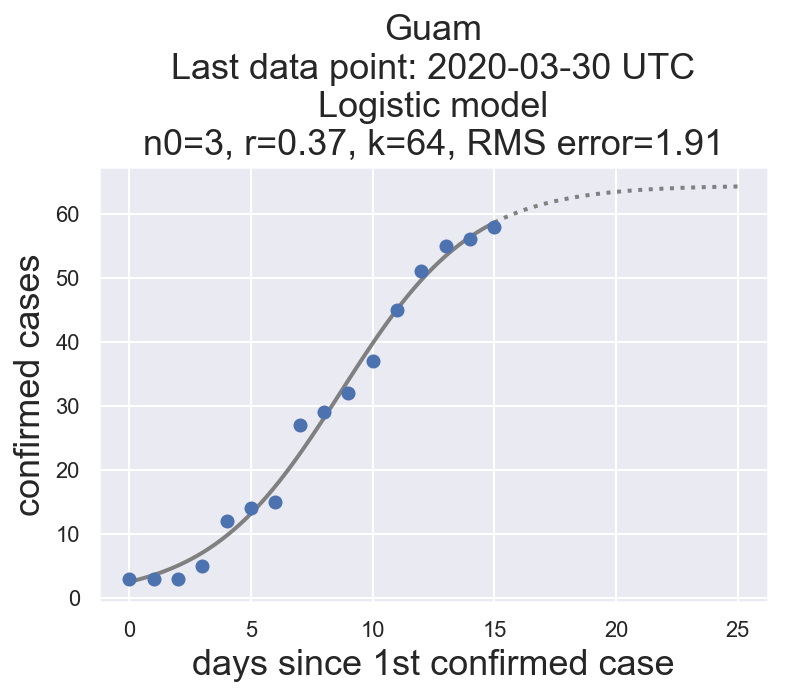

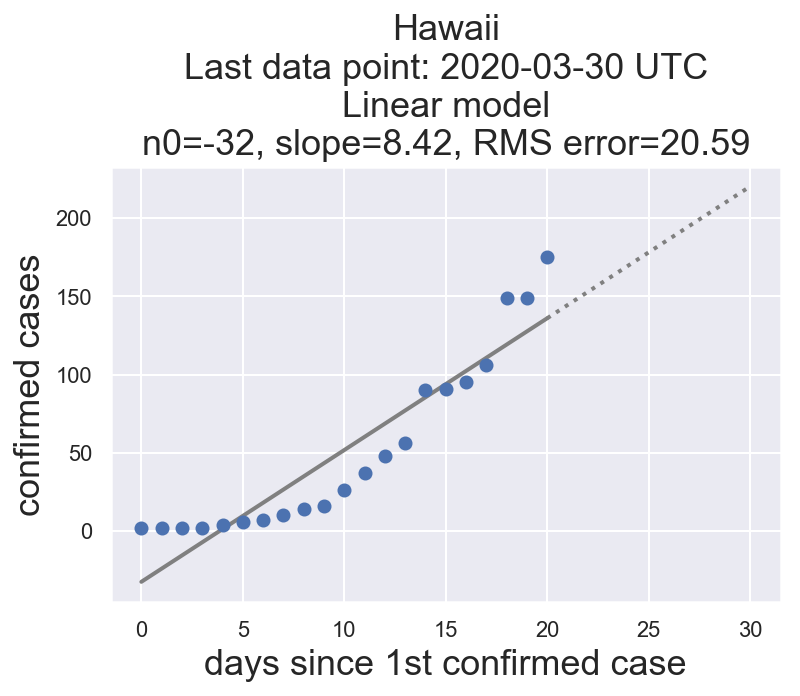

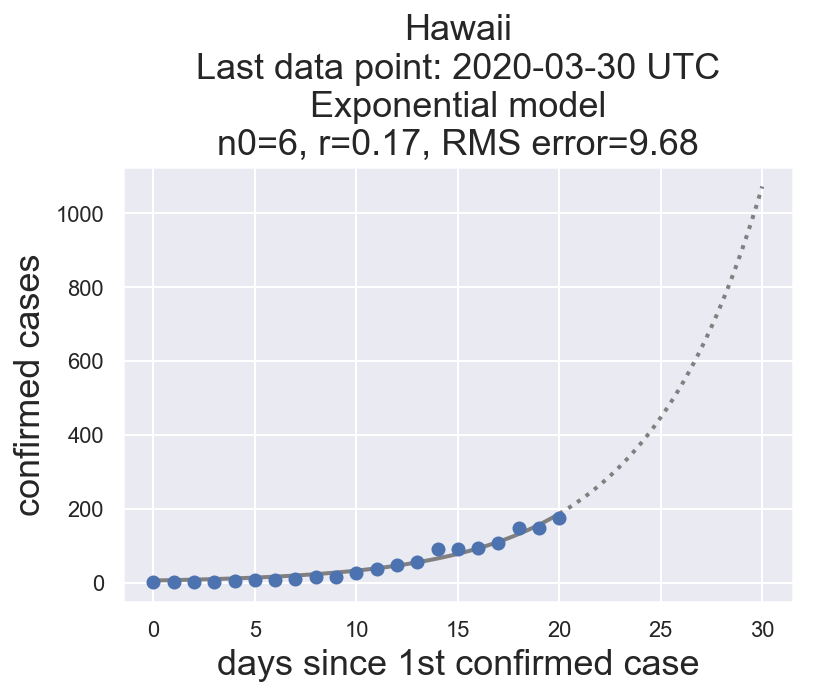

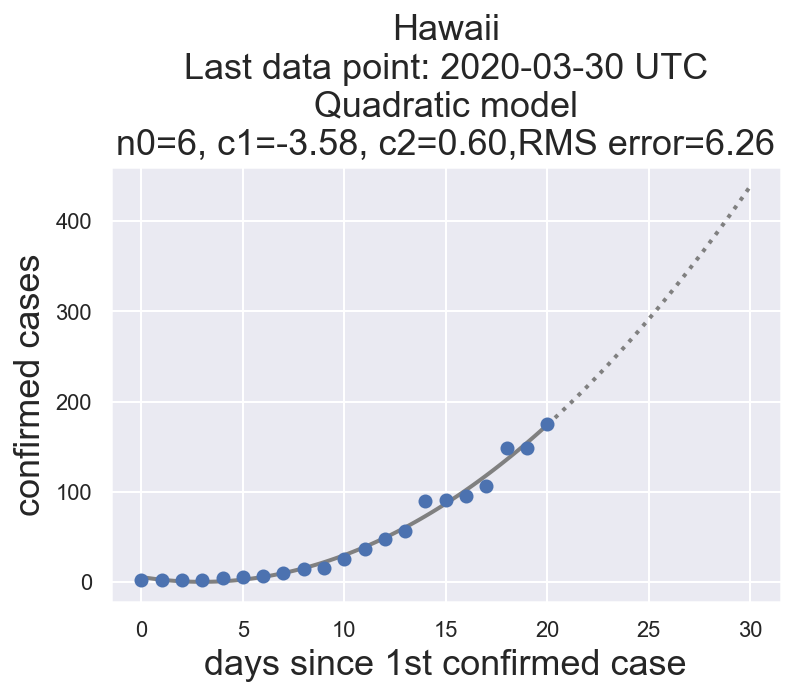

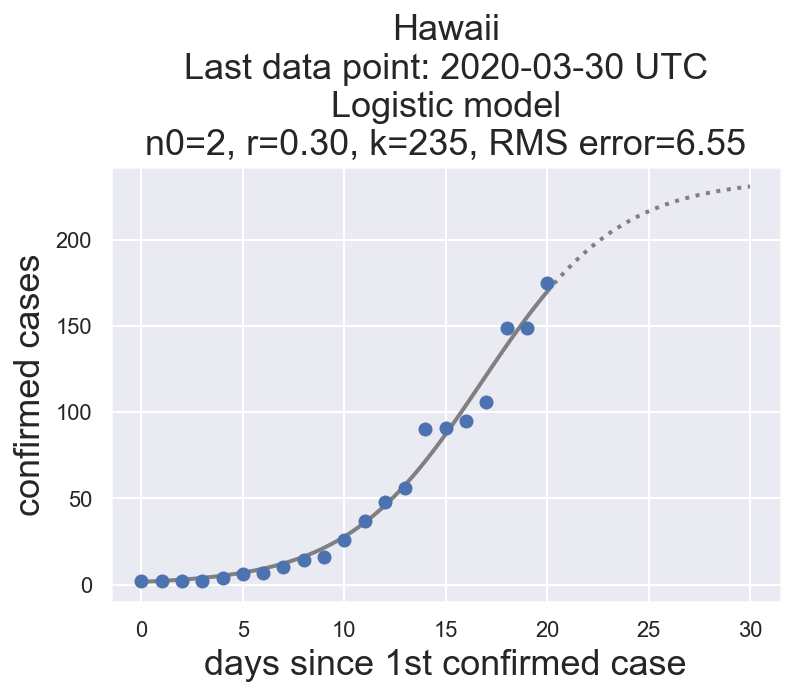

In [20]:
place_names = ['Guam', 'Hawaii']

# Initial parameters for linear model
y_intercept_0 = 1
slope_0 = 10
p0_linear = np.array([y_intercept_0, slope_0])

# Initial parameters for quadratic model
n_0 = 1
c1_0 = 4
c2_0 = 0
p0_quadratic = np.array([n_0, c1_0, c2_0])

# Initial parameters for exponential model
n_0 = 1
r_0 = 0.33
p0_exponential = np.array([n_0, r_0])

# Initial parameters for logistic_model
#K_0 = 1000
K_0 = 200
P0_0 = 1
lr_0 = 0.33
p0_logistic = np.array([K_0, P0_0, lr_0])

for place_name in place_names:
    df = get_data(place_name)
    fit_curve(place_name=place_name, df=df, model=linear_model, p0=p0_linear, extrapolated_days=10)        
    fit_curve(place_name=place_name, df=df, model=exponential_model, p0=p0_exponential, extrapolated_days=10)        
    fit_curve(place_name=place_name, df=df, model=quadratic_model, p0=p0_quadratic, extrapolated_days=10)        
    fit_curve(place_name=place_name, df=df, model=logistic_model, p0=p0_logistic, extrapolated_days=10)     
    plot_logistic_model_derivative(place_name)    